In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def legendre_polynomial_basis(n: int, x: float) -> np.array:
    """
    Creates the Legendre polynomial basis up to degree n-1.

    Parameters:
        n (int): Degree to which the Legendre polynomial is evaluated.
        x (float): Point at which the Legendre polynomial is evaluated.

    Returns:
        np.array: Bases of the Legendre polynomial at x.
    """
    basis = np.zeros(n)
    if n >= 1:
        basis[0] = 1.0
    if n >= 2:
        basis[1] = x
        for i in range(2, n):
            basis[i] = (2*i - 1)/i * x * basis[i-1] - (i - 1)/i * basis[i-2]
    return basis


def legendre_polynomial(n: int, point: float) -> float:
    """
    Evaluates the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the Legendre polynomial is evaluated.
        x (float): Point at which the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the n-th Legendre polynomial at x.
    """
    value = legendre_polynomial_basis(n + 1, point)[n]
    return value


def legendre_derivative(n: int, x: float) -> float:
    """
    Evaluates the derivative of the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the derivative of the Legendre polynomial is evaluated.
        x (float): Point at which the derivative of the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the derivative of tghe n-th Legendre polynomial at x.
    """
    if n == 0:
        return 0.0
    Pn = legendre_polynomial(n, x)
    Pn_1 = legendre_polynomial(n - 1, x)
    return n / (x**2 - 1.0) * (x * Pn - Pn_1)


In [3]:
def legendre_quadrature(integrand, m: int = 32) -> float:
    """
    Computes the Gauss-Legendre of a given function with arbitrary precision.

    Parameters:
        integrand (callable): Function to be integrated.
        m (int, optional): Degree of the quadrature.

    Returns:
        float: Value of the integral.
    """
    pts, wts = np.polynomial.legendre.leggauss(m)
    vals = np.array([integrand(x) for x in pts])
    return np.sum(wts * vals)


def legendre_quadrature_vec(integrand, m: int = 32, d: int | None = None) -> np.array:
    """
    Vector-valued Gauss-Legendre quadrature for each component.

    Parameters:
        integrand (callable): Vector-valued function.
        m (int): Degree of the quadrature.
        d (int): Dimension of output.

    Returns:
        np.array: Integral values per component.
    """
    if d is None:
        d = int(integrand(0.0).size)
    comps = []
    for k in range(d):
        def comp_fun(s, k=k):
            return integrand(s)[k]
        comps.append(legendre_quadrature(comp_fun, m))
    return np.array(comps)

In [4]:
def affine_trafo(x: np.array, a: float, b: float) -> np.array:
    """
    Performs an affine transformation from [-1,1] to [a,b]

    Parameters:
        x (np.array): Interval from [-1,1]
        a (float): Start of new interval
        b (float): End of new interval

    Returns:
        np.array: New interval from [a,b].
    """
    return (b-a)/2 * x + (a+b)/2


# Not needed yet
def inverse_trafo(x: np.array, a: float, b: float) -> np.array:
    """
    Performs an affine transformation from [a,b] to [-1,1]

    Parameters:
        x (np.array): Interval from [a,b]
        a (float): Start of new interval
        b (float): End of new interval

    Returns:
        np.array: New interval from [-1,1].
    """
    return 2/(b-a) * x - (a+b)/(b-a)


def build_vandermonde(s_grid: np.array, n: int) -> np.array:
    """
    Builds Vandermonde Matrix to interpolate solution

    Parameters:
        s_grid (np.array): Points at which the Vandermonde matrix is evaluated
        n (int): Number of coefficients for the Legendre Basis

    Returns:
        np.array: Values of the interpolating polynomial.
    """
    V = np.empty((s_grid.size, n))
    for i, s in enumerate(s_grid):
        for j in range(n):
            V[i, j] = legendre_polynomial(j, s)
    return V


def f(u: np.array) -> np.array:
    """
    RHS of the system
    """
    return np.array([u[1], -u[0]])

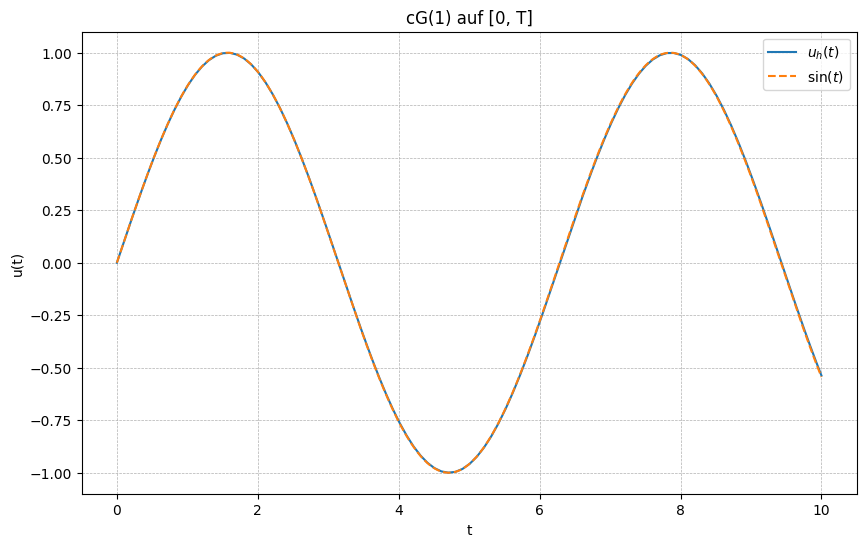

In [5]:
def make_interval_residual(f, n: int, u_initial: np.array, dt: float, quad_m: int = 64):
    """
    Vector residual for one time interval using affine transformation to reference element [-1,1].

    Parameters:
        f (callable): RHS function, returns np.array of shape (d,).
        n (int): Number of dofs per interval (Legendre basis size).
        u_initial (np.array): Initial value u(t_n) used as continuity constraint at s = -1.
        dt (float): Time step size.
        quad_m (int): Gauss-Legendre quadrature degree.

    Returns:
        callable: residual function R(c_flat) for solving coefficients c.
    """
    alpha = 2.0 / dt
    d = int(u_initial.size)

    def residual(c_flat: np.array) -> np.array:
        c = c_flat.reshape(n, d)
        r = np.zeros((n, d))
        for i in range(n - 1):
            def integrand(s: float) -> np.array:
                u_val = np.zeros(d)
                du_val = np.zeros(d)
                for j in range(n):
                    Pj = legendre_polynomial(j, s)
                    dPj = legendre_derivative(j, s)
                    u_val += c[j, :] * Pj
                    du_val += c[j, :] * dPj
                return (alpha * du_val - f(u_val)) * legendre_polynomial(i, s)
            r[i, :] = legendre_quadrature_vec(integrand, m=quad_m, d=d)
        u_boundary = np.zeros(d)
        for j in range(n):
            u_boundary += c[j, :] * legendre_polynomial(j, -1.0)
        r[-1, :] = u_boundary - u_initial
        return r.reshape(n * d)
    return residual


def solve_cG_time(f, u0: np.ndarray, T: float, N: int, n_dofs: int, quad_m: int = 64, grid: int = 100) -> tuple:
    """
    Solve u'(t) = f(u(t)) on [0, T] via piecewise cG in time for systems of size d.

    Parameters:
        f (callable): RHS function f(u) returning.
        u0 (np.ndarray): Initial value u(0) with.
        T (float): Final time.
        N (int): Number of time intervals.
        n_dofs (int): Legendre basis size per interval.
        quad_m (int): Quadrature degree per interval.
        grid (int): Number of interpolation points per interval.

    Returns:
        (t_all, U_all): Time grid and solution values.
    """
    t_nodes = np.linspace(0.0, T, N + 1)
    t_all = []
    u_rows = []
    u_left = u0.copy()
    d = u0.size

    for k in range(N):
        t_n, t_np1 = t_nodes[k], t_nodes[k + 1]
        dt = t_np1 - t_n
        residual = make_interval_residual(f, n_dofs, u_left, dt, quad_m=quad_m)
        x0 = np.zeros((n_dofs, d))
        x0[0, :] = u_left
        c_flat = scipy.optimize.fsolve(residual, x0.reshape(n_dofs * d))
        c = c_flat.reshape(n_dofs, d)
        s_grid = np.linspace(-1.0, 1.0, grid)
        V = build_vandermonde(s_grid, n_dofs)
        u_vals = V @ c
        t_grid = affine_trafo(s_grid, t_n, t_np1)
        if k == 0:
            t_all.extend(t_grid.tolist())
            u_rows.extend(u_vals.tolist())
        else:
            t_all.extend(t_grid[1:].tolist())
            u_rows.extend(u_vals[1:].tolist())
        u_right = np.zeros(d)
        for j in range(n_dofs):
            u_right += c[j, :] * legendre_polynomial(j, 1.0)
        u_left = u_right
    return np.array(t_all), np.array(u_rows)


t_all, U_all = solve_cG_time(
    f,
    u0=np.array([0.0, 1.0]),
    T=10.0,
    N=100,
    n_dofs=2,
    quad_m=64,
    grid=100,
)

u1_exact = np.sin(t_all)
u2_exact = np.cos(t_all)
plt.figure(figsize=(10, 6))
plt.plot(t_all, U_all[:, 0], label="$u_h(t)$")
plt.plot(t_all, u1_exact, '--', label="$\\sin(t)$")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("cG(1) auf [0, T]")
plt.show()